# Red Wine Making Simulator Notebook

Creators: Vinny Kanigicherla, Leo Chang, Kyle Yin

**Description:** "Red Wine Making Simulator" is a game where players choose grapes, manage fermentation, and adjust wine composition to produce and rate their own red wines. This interactive simulator combines real winemaking processes with real red wine quality data. Discover the intricacies of wine production, from grape selection to the final rating.

**Notebook Contents**:
1. Data Processing and Analysis: The notebook starts by loading a wine dataset, which includes various properties of wine samples along with their quality ratings. It involves cleaning the data, handling missing values, and possibly normalizing or standardizing the features. Then, it performs exploratory data analysis (EDA) to uncover trends and patterns, using visualizations like histograms and scatter plots to understand the relationships between different wine properties and quality.
2. Pattern Recognition and Insights: Through EDA, the notebook identifies critical factors that affect wine quality, such as acidity, sugar content, and alcohol level. These insights are essential for both improving the machine learning model's accuracy and informing game mechanics in the "Red Wine Making Simulator".
3. Machine Learning Model - Wine Evaluator: The notebook uses the processed data to develop a machine learning model that predicts the quality of wine based on its physicochemical properties. Techniques like Random Forest and Support Vector Machines are utilized, and the model's performance is evaluated using metrics like precision, recall, and F1-score.

##### Installing Necessary Libraries

In [7]:
!pip install numpy --quiet
!pip install pandas --quiet
!pip install matplotlib --quiet
!pip install seaborn --quiet
!pip install scikit-learn --quiet

In [8]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn
import warnings

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
from sklearn.preprocessing import StandardScaler, LabelEncoder

from sqlalchemy import *

##### Data Loading

In [9]:
github_url = 'https://raw.githubusercontent.com/aniruddhachoudhury/Red-Wine-Quality/master/winequality-red.csv'
red_wine_data = pd.read_csv(github_url)
print('Wine Quality Dataset:')
print(red_wine_data.head())

Wine Quality Dataset:
   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5 

### Feature Engineering

AIM: Uses label encoder for dividing to wine quality ratings into 2 categories: Low Quality (0) and High Quality (1)

quality
high    1382
low      217
Name: count, dtype: int64
quality
0    1382
1     217
Name: count, dtype: int64


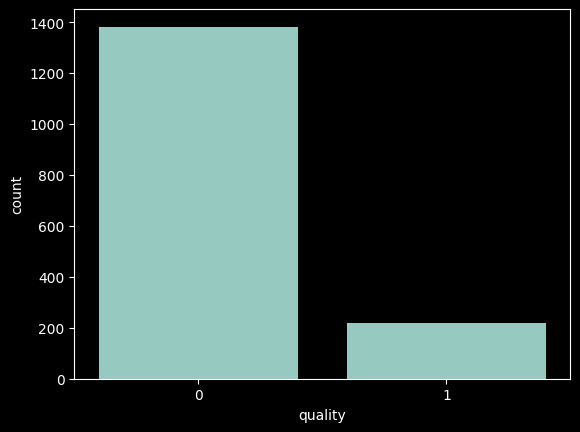

In [10]:
dividers = [2, 6, 8]  # Adjust the upper bin to include 8
possible_preds = ['high', 'low']
red_wine_data['quality'] = pd.cut(red_wine_data['quality'], bins=dividers, labels=possible_preds)

print(red_wine_data['quality'].value_counts())

if len(red_wine_data['quality'].value_counts()) == 2:
    label_quality = LabelEncoder()
    red_wine_data['quality'] = label_quality.fit_transform(red_wine_data['quality'])
else:
    print("Binning did not result in two distinct categories.")

# Check the new distribution of the encoded 'quality'
print(red_wine_data['quality'].value_counts())

# Plot the distribution
sns.countplot(x="quality", data=red_wine_data)
plt.show()

In [11]:
red_wine_data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0
1,7.8,0.88,0.00,2.6,0.098,25.0,67.0,0.9968,3.20,0.68,9.8,0
2,7.8,0.76,0.04,2.3,0.092,15.0,54.0,0.9970,3.26,0.65,9.8,0
3,11.2,0.28,0.56,1.9,0.075,17.0,60.0,0.9980,3.16,0.58,9.8,0
4,7.4,0.70,0.00,1.9,0.076,11.0,34.0,0.9978,3.51,0.56,9.4,0


### Exploratory Data Analysis (EDA)

### SQL Database Exploration via. SingleStore Database

In [12]:
# Create a Connection
from sqlalchemy import *

db_connection = create_engine(connection_url)

# Store the Dataframe
red_wine_data.to_sql(
    "wine_data",
    con = db_connection,
    if_exists = "replace",
    index = False,
    chunksize = 1000
)

1599

In [13]:
%%sql
SELECT * FROM wine_data LIMIT 5

fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
6.8,0.67,0.02,1.8,0.05,5.0,11.0,0.9962,3.48,0.52,9.5,0
4.6,0.52,0.15,2.1,0.054,8.0,65.0,0.9934,3.9,0.56,13.1,0
8.6,0.38,0.36,3.0,0.081,30.0,119.0,0.997,3.2,0.56,9.4,0
7.6,0.51,0.15,2.8,0.11,33.0,73.0,0.9955,3.17,0.63,10.2,0
10.2,0.42,0.57,3.4,0.07,4.0,10.0,0.9971,3.04,0.63,9.6,0


In [14]:
%%sql
-- Null Value Detection
SELECT 
    COUNT(*) - COUNT(`fixed acidity`) AS null_fixed_acidity,
    COUNT(*) - COUNT(`volatile acidity`) AS null_volatile_acidity,
    COUNT(*) - COUNT(`citric acid`) AS null_citric_acid,
    COUNT(*) - COUNT(`residual sugar`) AS null_residual_sugar,
    COUNT(*) - COUNT(chlorides) AS null_chlorides,
    COUNT(*) - COUNT(`free sulfur dioxide`) AS null_free_sulfur_dioxide,
    COUNT(*) - COUNT(`total sulfur dioxide`) AS null_total_sulfur_dioxide,
    COUNT(*) - COUNT(density) AS null_density,
    COUNT(*) - COUNT(pH) AS null_pH,
    COUNT(*) - COUNT(sulphates) AS null_sulphates,
    COUNT(*) - COUNT(alcohol) AS null_alcohol,
    COUNT(*) - COUNT(quality) AS null_quality
FROM wine_data;

null_fixed_acidity,null_volatile_acidity,null_citric_acid,null_residual_sugar,null_chlorides,null_free_sulfur_dioxide,null_total_sulfur_dioxide,null_density,null_pH,null_sulphates,null_alcohol,null_quality
0,0,0,0,0,0,0,0,0,0,0,0


In [15]:
%%sql
-- Looking at Average Values of Red Wine feature by Quality
SELECT 
    quality,
    AVG(`fixed acidity`) AS average_fixed_acidity,
    AVG(`volatile acidity`) AS average_volatile_acidity,
    AVG(`citric acid`) AS average_citric_acid,
    AVG(`residual sugar`) AS average_residual_sugar,
    AVG(chlorides) AS average_chlorides,
    AVG(`free sulfur dioxide`) AS average_free_sulfur_dioxide,
    AVG(`total sulfur dioxide`) AS average_total_sulfur_dioxide,
    AVG(density) AS average_density,
    AVG(pH) AS average_pH,
    AVG(sulphates) AS average_sulphates,
    AVG(alcohol) AS average_alcohol
FROM 
    wine_data
GROUP BY 
    quality
ORDER BY 
    AVG(`fixed acidity`) DESC;

quality,average_fixed_acidity,average_volatile_acidity,average_citric_acid,average_residual_sugar,average_chlorides,average_free_sulfur_dioxide,average_total_sulfur_dioxide,average_density,average_pH,average_sulphates,average_alcohol
1,8.84700460477908,0.40552995347070253,0.37649769500790653,2.708755754106056,0.07591244279651597,13.981566820276498,34.88940092165899,0.9960302781948845,3.288801846965667,0.7434562196105307,11.518049169795304
0,8.236830679276572,0.5470224302342935,0.2544066568097981,2.5121201075796797,0.0892807527751205,16.17221418234443,48.285817655571634,0.9968591685664292,3.3146164981397637,0.6447539789502424,10.251037119438955


### Seaborn Visualizations Exploration

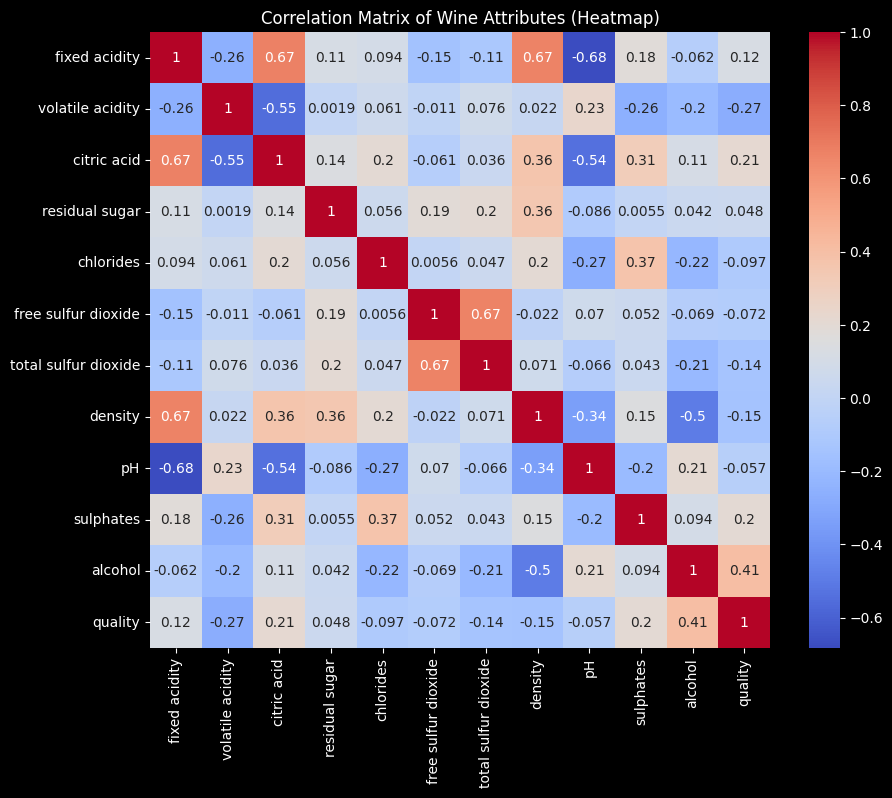

In [16]:
# Correlation Matrix to see relations between all variables
corr = red_wine_data.corr()
plt.figure(figsize=(10, 8))

sns.heatmap(corr, annot=True, cmap='coolwarm')
plt.title("Correlation Matrix of Wine Attributes (Heatmap)")
plt.show()

In [17]:
# Visualization of Distribution of Feature Over Quality Ranges
# def categorize_quality(quality):
#     return f'{quality}-{quality+1}'

# # Apply the function to create a new 'quality_range' column
# red_wine_data['quality_range'] = red_wine_data['quality'].apply(categorize_quality)

# # Create the histogram
# sns.histplot(data=red_wine_data, x='quality_range', palette='{INPUT GOES HERE}')

# plt.title('Distribution of Citric Acid across Quality Ranges')
# plt.xlabel('Quality Range')
# plt.ylabel('{INPUT GORES HERE')
# plt.show()

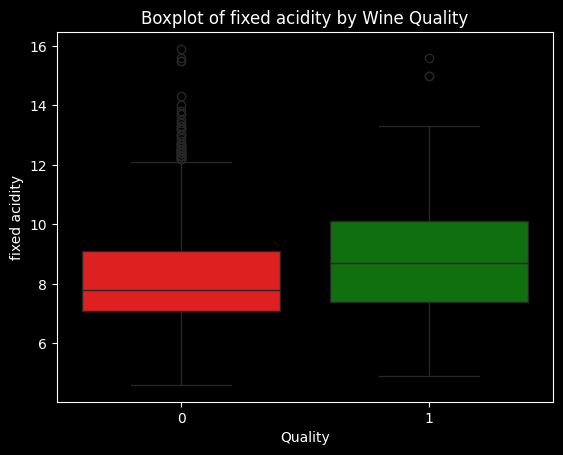

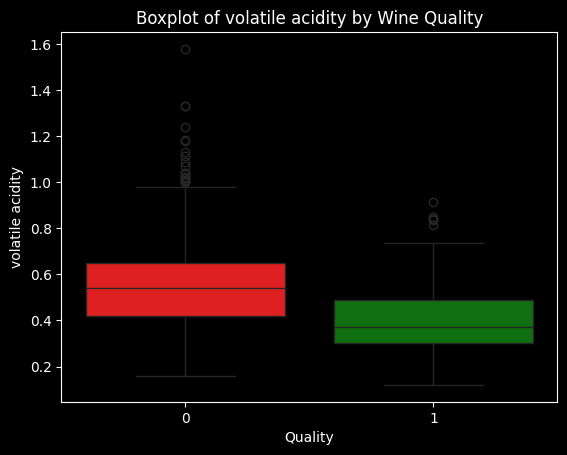

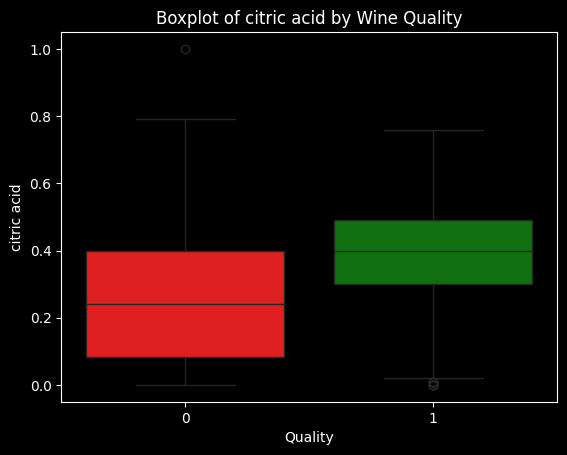

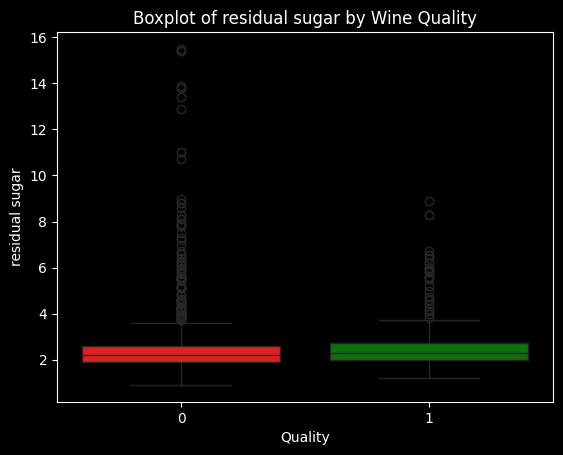

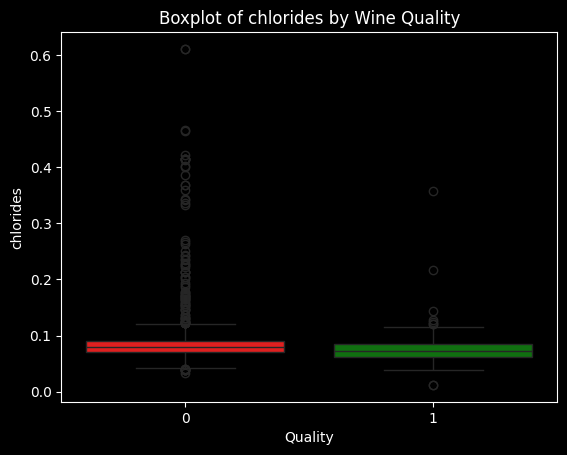

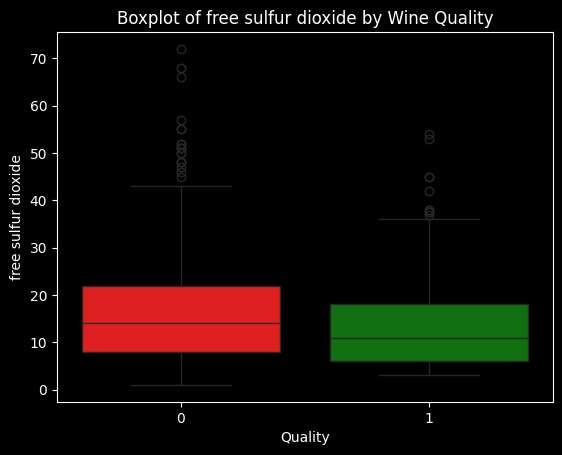

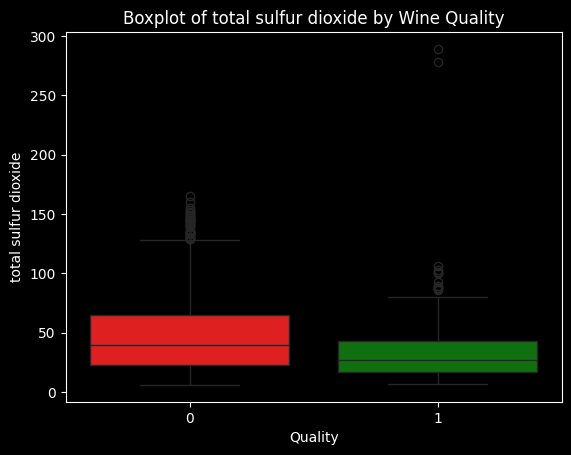

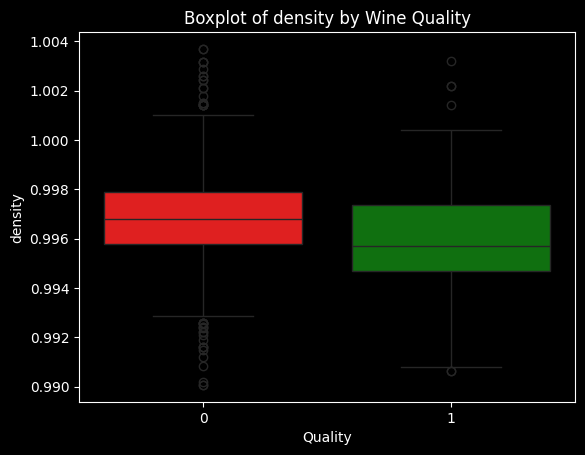

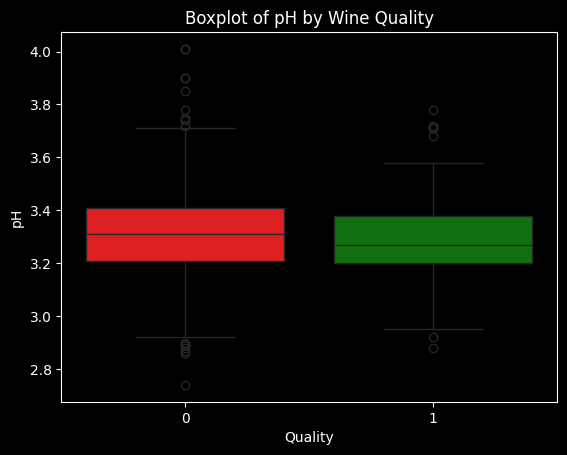

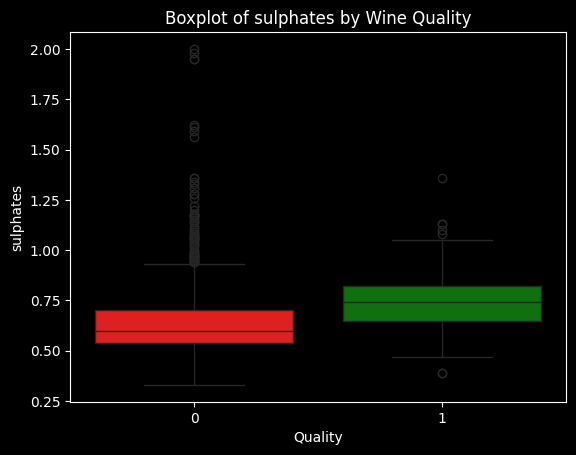

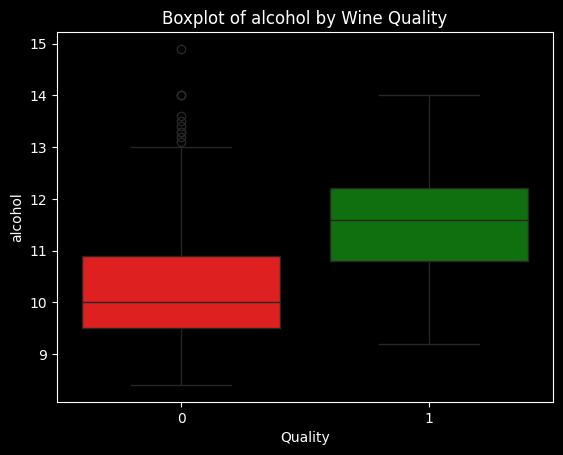

In [18]:
# Key EDA Compoent: Boxplots
# 0 - Low, 1 - High
for feature in red_wine_data.columns[:-1]:
    sns.boxplot(x='quality', y=feature, hue='quality', data=red_wine_data, palette=['red', 'green'], legend=False)
    plt.title(f'Boxplot of {feature} by Wine Quality')
    plt.xlabel('Quality')
    plt.ylabel(feature)
    plt.show()

### Exploring Models

#### Support Vector Machine (SVM)

**What and why?**

A Support Vector Machine (SVM) is a type of supervised learning algorithm used in machine learning. It is adept at handling intricate tasks in classification, regression, and outlier detection. SVM operates by executing optimal transformations of data to establish boundaries or distinctions among data points, guided by predetermined classes, labels, or outcomes. This method allows for effective problem-solving in complex scenarios involving data categorization and prediction. Why SVM? Support Vector Machines (SVMs) are particularly effective for supervised learning tasks involving classification of datasets with multiple variables, like the red wine quality dataset. This is because SVMs are very god at finding patterns in data where the classification (such as wine quality) depends on several variables (like acidity, sugar content, alcohol level, etc.). By efficiently handling these multiple features, SVMs can accurately classify the wine quality, making them a suitable choice for such complex, multi-variable classification tasks.

In [ ]:
X = red_wine_data.drop('quality', axis=1)
y = red_wine_data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

svm = SVC(kernel='linear') 
svm.fit(X_train, y_train)

y_pred = svm.predict(X_test)

print("Classification Report:")
print(classification_report(y_test, y_pred, zero_division=0))  # Added zero_division parameter
print("Accuracy Score:", accuracy_score(y_test, y_pred))

#### Random Forest Classifier

**What and why?**

A Random Forest Classifier is a machine learning model that builds several decision trees and merges their outcomes. It is like a team of decision trees where each gives their decision, and the final decision is made based on the majority vote. This model is especially useful for handling datasets with many features, like in the red wine quality dataset. The red wine dataset likely includes various attributes like acidity, alcohol content, and sugar levels. Random Forest works well for the Red Wine Dataset because:

1. Handles Complex Interactions: It can understand complex relationships between these features and how they affect wine quality.
2. Reduces Overfitting: Unlike a single decision tree, which might focus too much on the training data (overfitting), Random Forest balances this by considering the insights of multiple trees.
3. Improves Accuracy: With multiple trees, it’s more likely to catch patterns and trends that a single tree might miss, leading to more accurate classifications of wine quality.
4. Feature Importance: Random Forest can also tell which features (like acidity or sugar level) are more important in determining the quality of the wine, providing valuable insights for wine analysis.

In [ ]:
from sklearn.ensemble import RandomForestClassifier

X = red_wine_data.drop('quality', axis=1)
y = red_wine_data['quality']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

random_forest = RandomForestClassifier(n_estimators=100, random_state=42)

random_forest.fit(X_train, y_train)

y_pred = random_forest.predict(X_test)

print("Classification_Report - ")
print(classification_report(y_test, y_pred))
print("Accuracy - ", accuracy_score(y_test, y_pred))

##### Final Model: Random Forest Classifier

In [ ]:
# Outputs whether the wine is low (0) or high (1) quality based on Random Forest Model
def wineEvaluator(wine_feature_vector, random_forest):
    warnings.filterwarnings('ignore')
    y_pred = random_forest.predict(np.array(wine_feature_vector).reshape(1, -1))
    return y_pred[0]

#Test on a red wine quality feature vector
wineEvaluator([5.4,	0.835,	0.08,	1.2,	0.046,	13.0,	93.0,	0.9924,	3.57,	0.85,	13.0], random_forest)